# Space X Falcon 9 First Stage Landing Prediction


## Webscraping SpaceX Data

We first need to grab webscraped data from this link: https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches

The format of the data is shown in the launch records below:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)

#### Importing the libraries needed for webscraping:

In [16]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np

#### Helper functions to process webscraped HTML Table:

In [18]:
def dateTime(tableCells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [dataTime.strip() for dataTime in list(tableCells.strings)][0:2]

def boosterVersion(tableCells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([boosterVersion for i,boosterVersion in enumerate( tableCells.strings) if i%2==0][0:-1])
    return out

def landingStatus(tableCells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in tableCells.strings][0]
    return out


def getMass(tableCells):
    mass=unicodedata.normalize("NFKD", tableCells.text).strip()
    if mass:
        mass.find("kg")
        newMass=mass[0:mass.find("kg")+2]
    else:
        newMass=0
    return newMass


def extractColumnFromHeader(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunmName = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunmName.strip().isdigit()):
        colunmName = colunmName.strip()
        return colunmName    


#### Requesting Falcon 9 Launch Wiki from URL

In [19]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [20]:
# Using get method to assign response to object
response = requests.get(static_url)
print(response.status_code)

# Use BeautifulSoup to create BeautifulSoup object from response
soup = BeautifulSoup(response.text)

# View title to ensure accuracy
print(soup.title)

200
<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


#### Extracting Column/Variable Names from Table Header

We need to collect all relevant column names by searching through the tables on the wiki page:

In [21]:
# Using find_all on BeautifulSoup object to find all tables and add to list
htmlTables = soup.find_all('table')
len(htmlTables)

25

In [22]:
# Check content of tables, where third table is target table
firstLaunchTable = htmlTables[2]
print(firstLaunchTable)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
<tr>
<th rowspan="2" scope="row" style="text-align:center;">1
</th>
<td>

In [24]:
# Extract column name from the header (<th>) only if it is not empty and add it to the list

columnNames = []

for row in firstLaunchTable.find_all('th'):
    name = extractColumnFromHeader(row)
    if name is not None and len(name) > 0:
        columnNames.append(name)
        
# Check content of columnNames
print(columnNames)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


#### Creating a Dataframe with Launch HTML Tables

In [36]:
launchDict= dict.fromkeys(columnNames)

# Remove an irrelvant column
del launchDict['Date and time ( )']

# Initialize the launch_dict with each value to be an empty list
launchDict['Flight No.'] = []
launchDict['Launch site'] = []
launchDict['Payload'] = []
launchDict['Payload mass'] = []
launchDict['Orbit'] = []
launchDict['Customer'] = []
launchDict['Launch outcome'] = []

# Add new columns
launchDict['Version Booster']=[]
launchDict['Booster Landing']=[]
launchDict['Date']=[]
launchDict['Time']=[]

To create the data frame, we need to parse launch record values into launchDict, with special symbols in account

In [40]:
extractedRow = 0

# Extract each table
for tableNumber,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    
    # Get table row
    for rows in table.find_all("tr"):
        
        # Verify if first table heading corresponds to launch number
        if rows.th:
            if rows.th.string:
                flightNumber = rows.th.string.strip()
                flag = flightNumber.isdigit()
        else:
            flag = False
        
        # Get table element
        row = rows.find_all('td')
        
        # If the table headnig corresponds to launch number, store cells into dictionary
        if flag:
            extractedRow += 1
            
            # Flight Number value: Add to key 'Flight No.''
            dataTimeList = dateTime(row[0])
            launchDict['Flight No.'].append(flightNumber)
            
            # Date value: Add to 'Date'
            date = dataTimeList[0].strip(',')
            launchDict['Date'].append(date)
            
            # Time value
            time = dataTimeList[1]
            launchDict['Time'].append(time)
              
            # Booster version
            bv = boosterVersion(row[1])
            if not(bv):
                bv = row[1].a.string
            launchDict['Version Booster'].append(bv)
            
            # Launch Site
            launchSite = row[2].a.string
            launchDict['Launch site'].append(launchSite)
            
            # Payload
            payload = row[3].a.string
            launchDict['Payload'].append(payload)
            
            # Payload Mass
            payLoadMass = getMass(row[4])
            launchDict['Payload mass'].append(payLoadMass)
            
            # Orbit
            orbit = row[5].a.string
            launchDict['Orbit'].append(orbit)
            
            # Customer
            if row[6].a:
                customer = row[6].a.string
            else:
                customer = ""
            launchDict['Customer'].append(customer)
        
            # Launch outcome
            launchOutcome = list(row[7].strings)[0]
            launchDict['Launch outcome'].append(launchOutcome)
            
            # Booster landing
            boosterLanding = landingStatus(row[8])
            launchDict['Booster Landing'].append(boosterLanding)
            

In [44]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launchDict.items() })
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster Landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10


***

## Data Wrangling the Dataset

Now, we need to find patterns in the data to determine what would be the label for training supervised models. In the data set, there are several different cases where the booster did not land successfully. 

For example, True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. 

True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.

True ASDS means the mission outcome was successfully landed on a drone ship False ASDS means the mission outcome was unsuccessfully landed on a drone ship.

We want to convert those outcomes into Training Labels 1 being successful, and 0 being unsuccessful

#### Reading in Data

In [18]:
import io

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv'
df = pd.read_csv(URL)
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


#### Calculate percentage of missing values in each attribute

In [19]:
df.isnull().sum()/df.shape[0]*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [20]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

#### Calculate number of launches on each site

In [22]:
df['LaunchSite'].value_counts()

LaunchSite
CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

Each launch aims for a dedicated orbit, including orbit types such as :

<b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth), or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25. Most of the manmade objects in outer space are in LEO 


<b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation


<b>GTO</b>: A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website


<b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time


<b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth


<b>HEO</b>: A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth


<b> ISS </b>: A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)


<b> MEO </b>: Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours


<b> HEO </b>: Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi)


<b> GEO </b>: It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation


<b> PO </b>: It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth


#### Calculate the number and occurence of each orbit

In [23]:
df['Orbit'].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

#### Calculate the number and occurence of mission outcome per orbit type

In [27]:
landingOutcomes = df['Outcome'].value_counts()
df['Outcome'].value_counts()

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [29]:
for i, outcome in enumerate(landingOutcomes.keys()):
    print(i, outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [30]:
# Take the "bad outcomes" (not true) and put them in another set
badOutcomes = set(landingOutcomes.keys()[[1,3,5,6,7]])
badOutcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [33]:
landingClass = []

# Label 0 for bad outcomes (none/false) label 1 for good outcomes (true)
for i in df['Outcome']:
    if i in badOutcomes:
        landingClass.append(0)
    else:
        landingClass.append(1)
        
df['Class'] = landingClass
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


With this, we can calculate the success rate of all landings, which comes out to around 67%

In [34]:
df['Class'].mean()

0.6666666666666666

***

## Exploratory Data Analysis with SQL

We will now be conducting Exploratory Data Analysis to determine the cost of the launch as well as reveal other information about the dataset. 

Using this information, we can see what attributes are correlated with successful landings. In addition, we will be converting categorical variables using one hot encoding, and preparing the data for a machine learning model.


#### Import proper libraries needed

In [42]:
!pip install sqlalchemy==1.3.9
!pip install ipython-sql

     ---------------------------------------- 2.0/2.0 MB 8.7 MB/s eta 0:00:00
     ---------------------------------------- 41.2/41.2 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.3.9
    Uninstalling SQLAlchemy-1.3.9:
      Successfully uninstalled SQLAlchemy-1.3.9


In [43]:
%load_ext sql

In [44]:
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [54]:
%sql sqlite:///my_data1.db

In [55]:
import pandas as pd
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

#### Remove any blank rows from the table

In [62]:
%%sql

create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
(sqlite3.OperationalError) table SPACEXTABLE already exists
[SQL: create table SPACEXTABLE as select * from SPACEXTBL where Date is not null]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


#### Show the names of the unique launch sites in the space mission

In [63]:
%%sql

SELECT DISTINCT LAUNCH_SITE
FROM SPACEXTBL ORDER BY 1;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
CCAFS SLC-40
KSC LC-39A
VAFB SLC-4E


#### Display 5 records where launch sites begin with 'CCA'

In [64]:
%%sql 

SELECT * 
FROM SPACEXTBL 
WHERE LAUNCH_SITE LIKE 'CCA%' LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-04-06,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-08-12,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,07:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-08-10,00:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-01-03,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


#### Display total payload mass carried by boosters launched by NASA

In [66]:
%%sql

SELECT SUM (PAYLOAD_MASS__KG_)
FROM SPACEXTBL
WHERE CUSTOMER='NASA (CRS)';

 * sqlite:///my_data1.db
Done.


SUM (PAYLOAD_MASS__KG_)
45596


#### Display average payload mass carried by booster version F9 v1.1

In [67]:
%%sql

SELECT AVG (PAYLOAD_MASS__KG_)
FROM SPACEXTBL
WHERE Booster_Version like 'F9 v1.1%';

 * sqlite:///my_data1.db
Done.


AVG (PAYLOAD_MASS__KG_)
2534.6666666666665


#### List date when first successful landing outcome in ground pad was achieved

In [68]:
%%sql

SELECT MIN(Date)
FROM SPACEXTBL
WHERE Mission_outcome LIKE 'Success%';


 * sqlite:///my_data1.db
Done.


MIN(Date)
2010-04-06


#### List total number of successful and failure mission outcomes

In [76]:
%%sql

SELECT MISSION_OUTCOME, COUNT(MISSION_OUTCOME)
FROM SPACEXTBL
WHERE MISSION_OUTCOME like 'Success%'

 * sqlite:///my_data1.db
Done.


Mission_Outcome,COUNT(MISSION_OUTCOME)
Success,100


#### List names of boosterversions which have carried max payload mass

In [77]:
%%sql

SELECT BOOSTER_VERSION
FROM SPACEXTBL
WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTBL)

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


####  List records for launch sites in the months in year 2015

In [78]:
%%sql 

SELECT BOOSTER_VERSION,LAUNCH_SITE,LANDING_OUTCOME
FROM SPACEXTBL
WHERE LANDING_OUTCOME LIKE "Failure%" and DATE('2015')

 * sqlite:///my_data1.db
Done.


Booster_Version,Launch_Site,Landing_Outcome
F9 v1.0 B0003,CCAFS LC-40,Failure (parachute)
F9 v1.0 B0004,CCAFS LC-40,Failure (parachute)
F9 v1.1 B1012,CCAFS LC-40,Failure (drone ship)
F9 v1.1 B1015,CCAFS LC-40,Failure (drone ship)
F9 v1.1 B1017,VAFB SLC-4E,Failure (drone ship)
F9 FT B1020,CCAFS LC-40,Failure (drone ship)
F9 FT B1024,CCAFS LC-40,Failure (drone ship)
F9 B5B1050,CCAFS SLC-40,Failure
F9 B5 B1056.4,CCAFS SLC-40,Failure
F9 B5 B1048.5,KSC LC-39A,Failure


#### Rank the count of landing outcomes between dates 2010 - 2017 in descending order

In [61]:
%%sql

SELECT landing_outcome, COUNT(*) AS "Count"
FROM SPACEXTBL
WHERE DATE BETWEEN '2010-06-04' and '2017-03-20'
GROUP BY landing_outcome
ORDER BY Count DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Count
No attempt,10
Success (ground pad),5
Success (drone ship),5
Failure (drone ship),5
Controlled (ocean),3
Uncontrolled (ocean),2
Precluded (drone ship),1
Failure (parachute),1


***

## Exploratory Data Analysis and Feature Engineering Using Pandas and MatplotLib

We will conduct an exploratory data analysis to decide what features to use and plot them on a variety of graphs. We can use these visualizations to see which type of orbit would allow for the returning of the first stage of the Falcon 9.

#### Import the libraries necessary

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857,0
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857,1
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857,1
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857,0
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857,0


#### Let's see how FlightNumber and Payload variables would affect launch outcome.

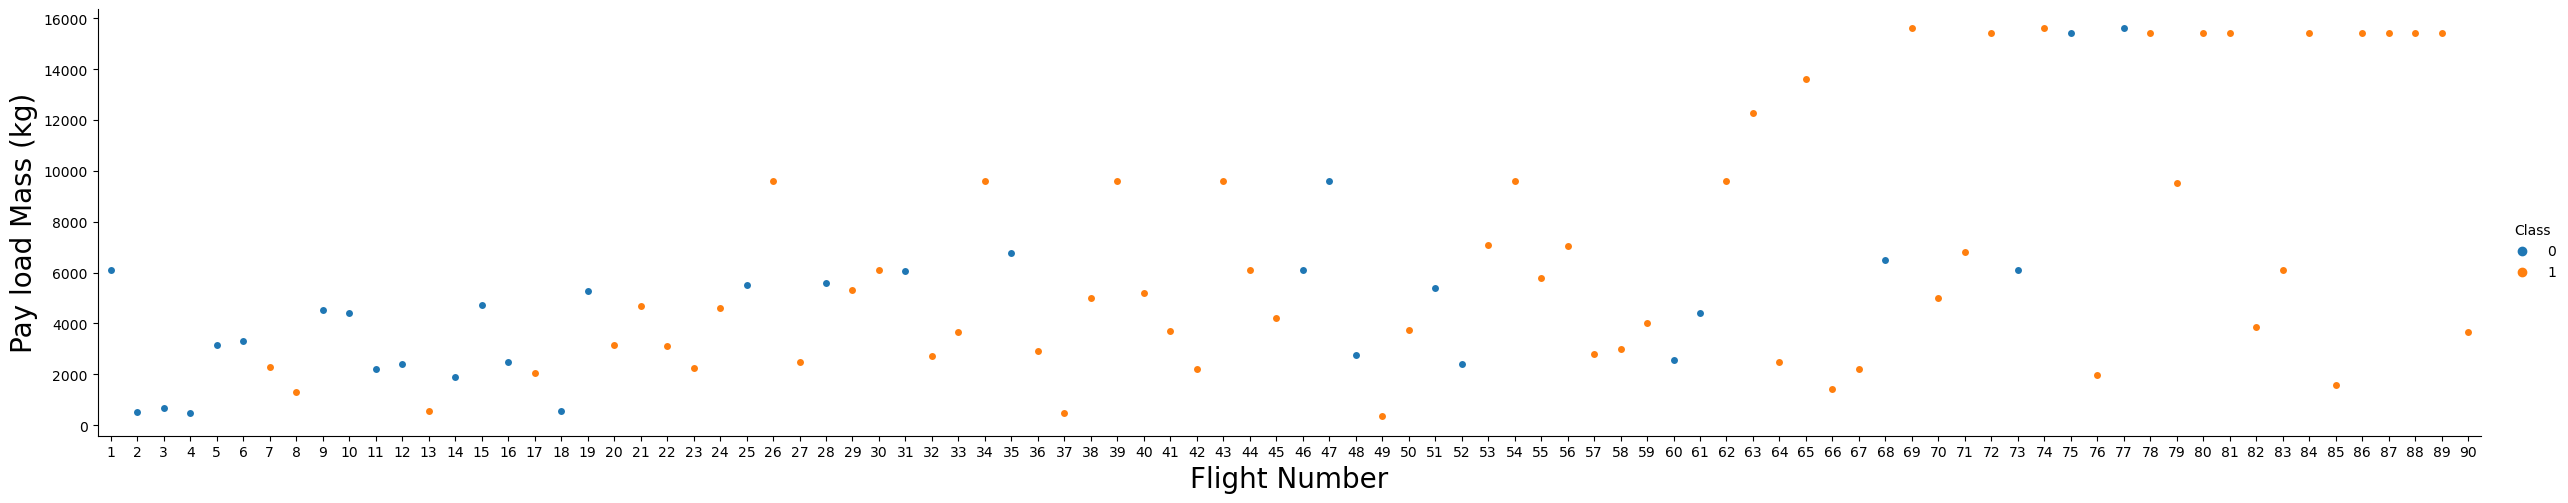

In [82]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

With this, we see that as te flight number increases, the first stage is more likely to land successfully. The payload mass is also important in that it seems that the more massive the payload, the less likely the first stage will return.

The data also shows that different launch sites have different success rates:

CCAFS LC-40 has a success rate of around 60%

KSCLC-39A has a success rate of around 77%

VAFB SLC 4E has a success rate of around 77%

#### Let's see how FlightNumber and LaunchSite affect the launch outcome.

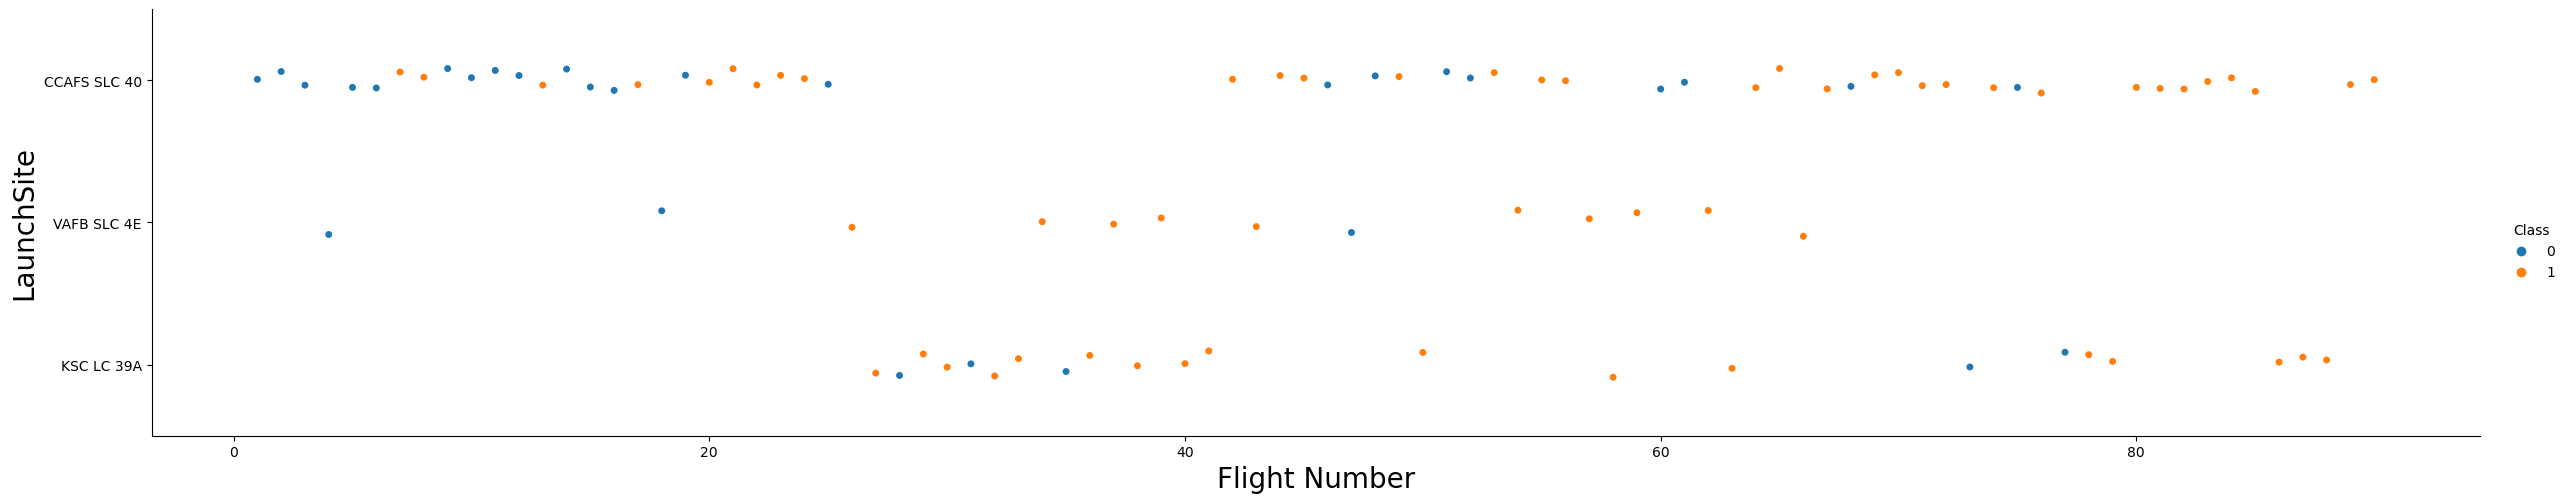

In [83]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

#### Let's visualize the relationship between Payload and Launchsite

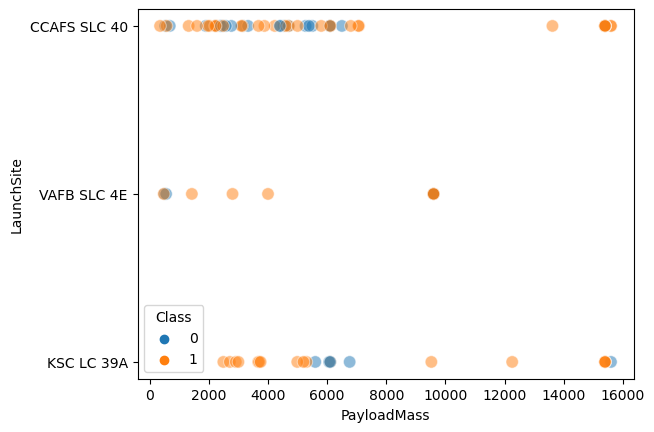

In [84]:
sns.scatterplot(x="PayloadMass", y="LaunchSite", data=df, alpha=0.5, hue="Class", s=80)
plt.xlabel("PayloadMass",fontsize=10)
plt.ylabel("LaunchSite",fontsize=10)
plt.show()

#### Let's visualize the relationship between FlightNumber and Orbit type

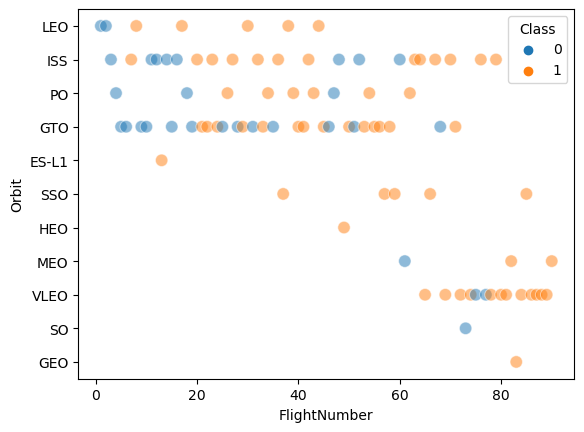

In [87]:
sns.scatterplot(x="FlightNumber", y="Orbit", data=df, alpha=0.5, hue="Class", s=80)
plt.xlabel("FlightNumber",fontsize=10)
plt.ylabel("Orbit",fontsize=10)
plt.show()

#### Let's visualize the relationship between Payload and Orbit type

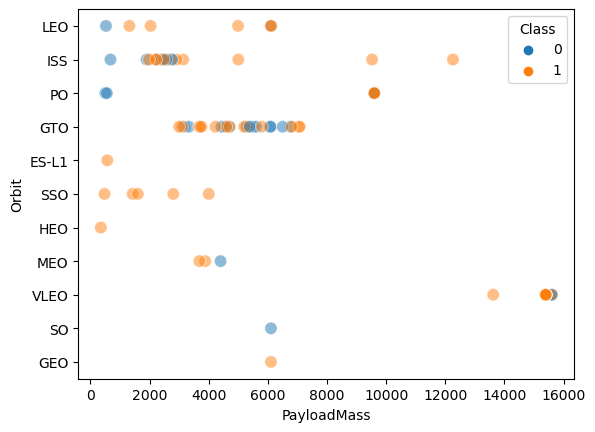

In [88]:
sns.scatterplot(x="PayloadMass", y="Orbit", data=df, alpha=0.5, hue="Class", s=80)
plt.xlabel("PayloadMass",fontsize=10)
plt.ylabel("Orbit",fontsize=10)
plt.show()

#### Plot the launch success on a yearly trend

In [89]:
year=[]
def Extract_year(date):
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year

<Axes: xlabel='year'>

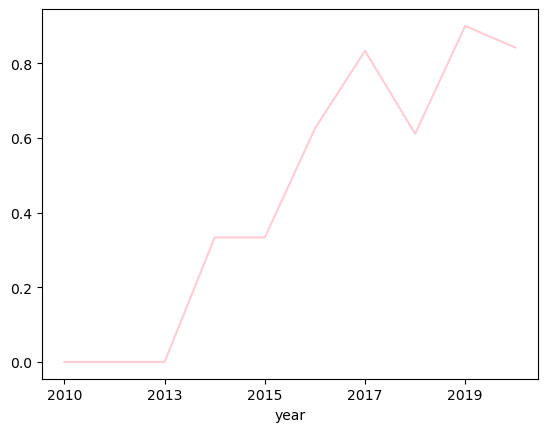

In [90]:
df1 = pd.DataFrame(Extract_year(df['Date']) , columns =['year'])
df1['Class']=df['Class']
df1.groupby('year')['Class'].mean().plot(kind='line', color=["pink"], alpha=0.8)

***

## Feature Engineering

We should create dummy variables to categorical columns, and cast all numeric columns to float64

In [91]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [92]:
features_one_hot = pd.get_dummies(features, columns = ['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [93]:
features_one_hot.astype(float)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15400.000000,3.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15400.000000,6.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88,89.0,15400.000000,3.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


***

## Machine Learning Prediction

In this portion, we will determine which is the best hyperparameter for the test data.


#### Import libraries necessary

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [98]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

#### Load the data

In [99]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [100]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


#### Create a NumPy array from the column Class and assign to variable Y

In [101]:
Y = data['Class'].to_numpy()

#### Standardize the data in X and reassign it back to X

In [103]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

#### Split the data into training and testing data

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (72, 83) (72,)
Test set: (18, 83) (18,)


In [105]:
Y_test.shape

(18,)

#### Create a logisitic regression, create a GridSearchCV object, and duisplay the best parameters with the accuracy and validation data

In [106]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, param_grid=parameters,scoring='accuracy', cv=10)
logreg_cv.fit(X_train, Y_train)
logreg_cv.best_params_

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


Calculate the accuracy on the test data, and view the confusion matrix

In [107]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

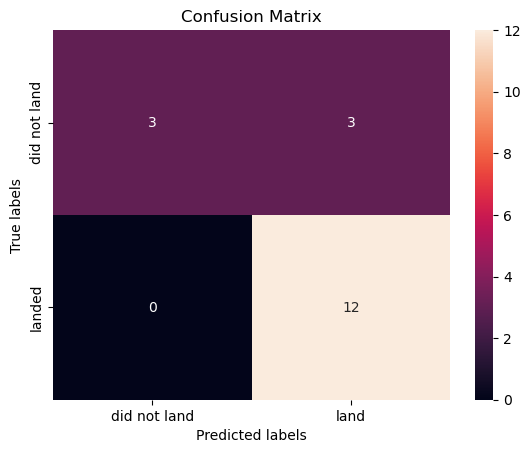

In [108]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

From the confusion matrix, we can see that the logistic regresion can distringuish between difference classes, but the major problem is that there are false positives

#### Create a support vector machine, create a GridSearchCV object, and fit the object to find the best parameters

In [109]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, param_grid=parameters,scoring='accuracy', cv=10)
svm_cv.fit(X_train, Y_train)
svm_cv.best_params_


print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


Calculate the accuracy on the test data, and view the confusion matrix

In [110]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

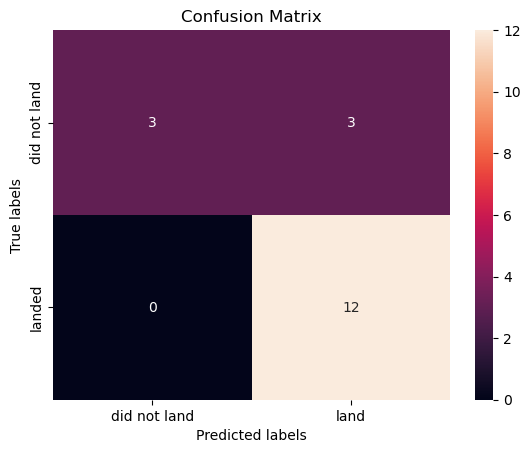

In [111]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Create a decision tree classifier, create a GridSearchCV object, and fit the object to find the best parameters

In [113]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, param_grid=parameters,scoring='accuracy', cv=10)
tree_cv.fit(X_train, Y_train)
tree_cv.best_params_

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.875


Calculate the accuracy on the test data, and view the confusion matrix

In [114]:
tree_cv.score(X_test, Y_test)


0.8333333333333334

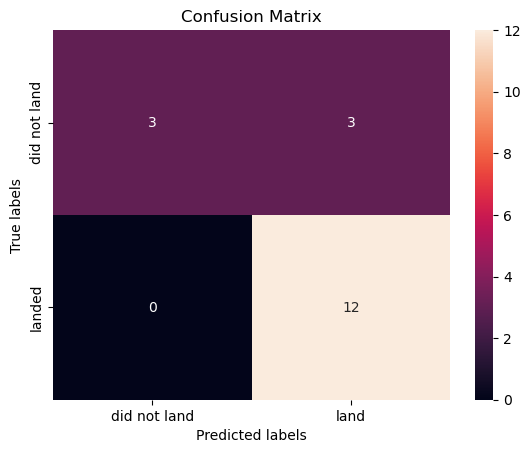

In [115]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### Create a k nearest neighbors object, create a GridSearchCV object, and fit the object to find the best parameters

In [116]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, param_grid=parameters,scoring='accuracy', cv=10)
knn_cv.fit(X_train, Y_train)
knn_cv.best_params_

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


Calculate the accuracy on the test data, and view the confusion matrix

In [117]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

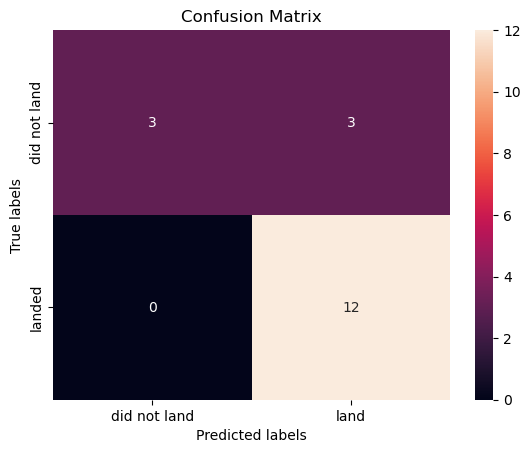

In [118]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)